In [1]:
# Вариант 9
import numpy as np
import matplotlib.pyplot as plt

# Параметры задачи
q_coeff = 1.0
p_coeff = 3.0

a_coeff = 1.0
b_coeff = 1.0
c_coeff = -1.0

f = lambda x, t: np.sin(x) * np.exp(-t)

# Граничные условия: alpha * u_x + beta * u = gamma
alpha0 = 0
beta0 = 1
gamma0 = lambda t: np.exp(-t)

alphal = 0
betal = 1
gammal = lambda t: -np.exp(-t)

# Начальное условие
psi1 = lambda x: np.cos(x)
psi2 = lambda x: -np.cos(x)

dpsi1 = lambda x: -np.sin(x)
ddpsi1 = lambda x: -np.cos(x)


L = np.pi
T_max = 1.0

# Аналитическое решение для проверки
def analytical_solution(x, t):
    return np.exp(-t) * np.cos(x)

# Сеточные параметры
h = 0.01
tau = 0.001

X = np.arange(0, L + h/2, h)
T = np.arange(0, T_max + tau/2, tau)

In [ ]:
# Вариант 4
import numpy as np
import matplotlib.pyplot as plt

# Параметры задачи
q_coeff = 1.0
p_coeff = 0.0

a_coeff = 1.0
b_coeff = 0.0
c_coeff = -5.0

f = lambda x, t: 0

# Граничные условия: alpha * u_x + beta * u = gamma
alpha0 = 1
beta0 = -2
gamma0 = lambda t: 0

alphal = 1
betal = -2
gammal = lambda t: 0

# Начальное условие
psi1 = lambda x: np.exp(2 * x)
psi2 = lambda x: 0

dpsi1 = lambda x: 2 * np.exp(2 * x)
ddpsi1 = lambda x: 4 * np.exp(2 * x)


L = 1
T_max = 1.0

# Аналитическое решение для проверки
def analytical_solution(x, t):
    return np.exp(2 * x) * np.cos(t)

# Сеточные параметры
h = 0.001
tau = 0.0001

X = np.arange(0, L + h/2, h)
T = np.arange(0, T_max + tau/2, tau)

Вычисление: Явная схема_two_point_first_order
Вычисление: Явная схема_three_point_second_order
Вычисление: Явная схема_two_point_second_order
Вычисление: Неявная схема_two_point_first_order
Вычисление: Неявная схема_three_point_second_order
Вычисление: Неявная схема_two_point_second_order


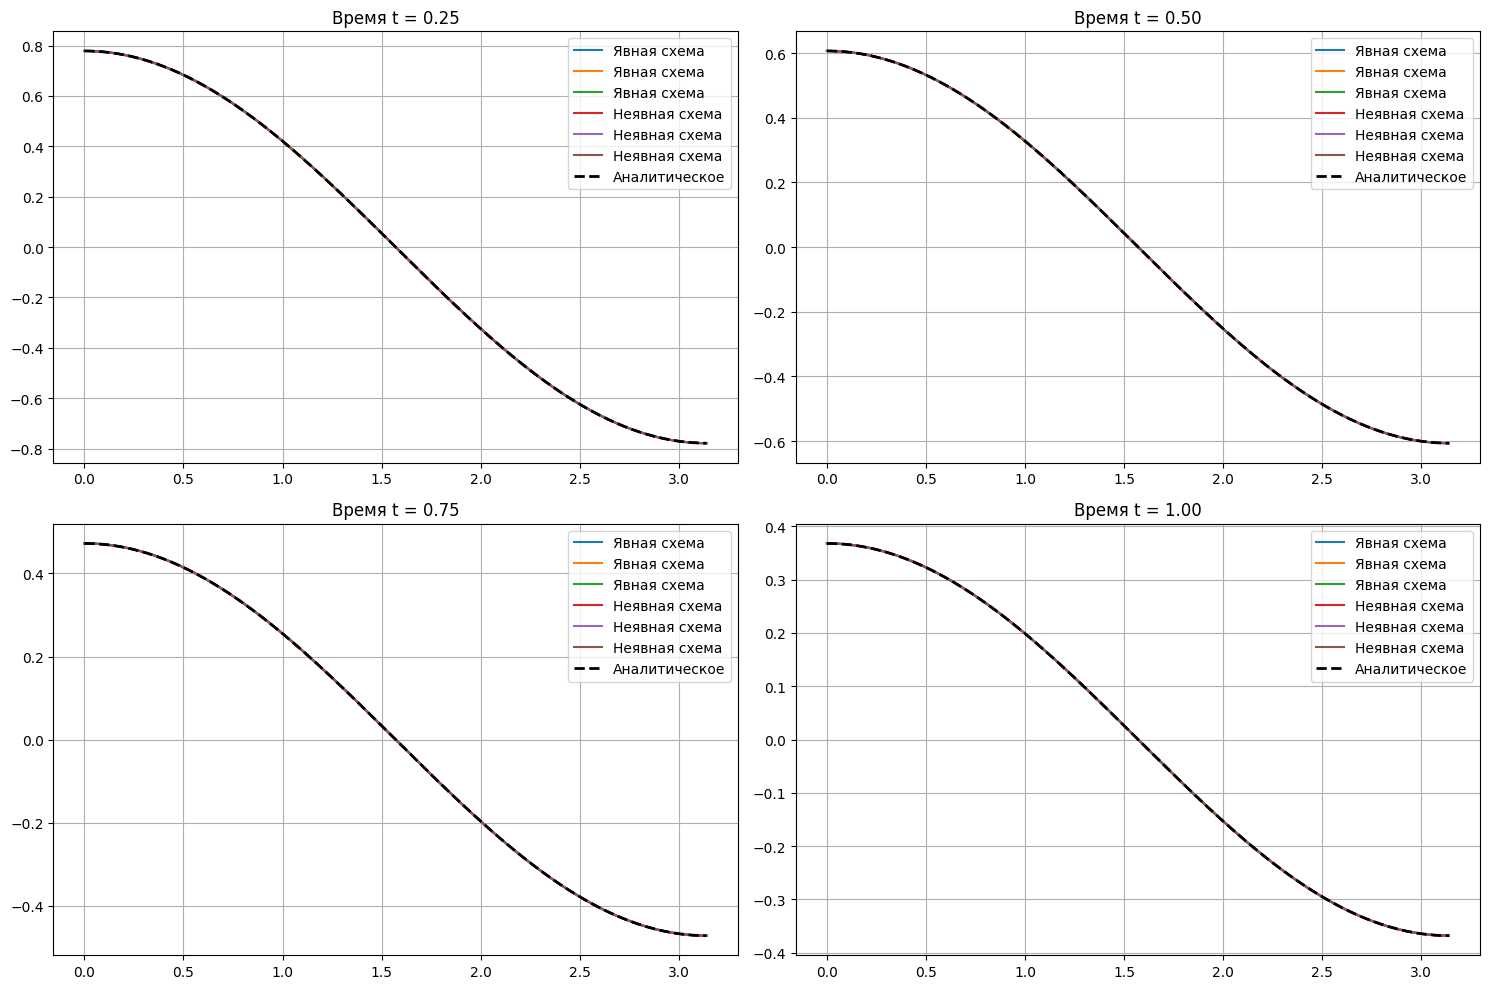

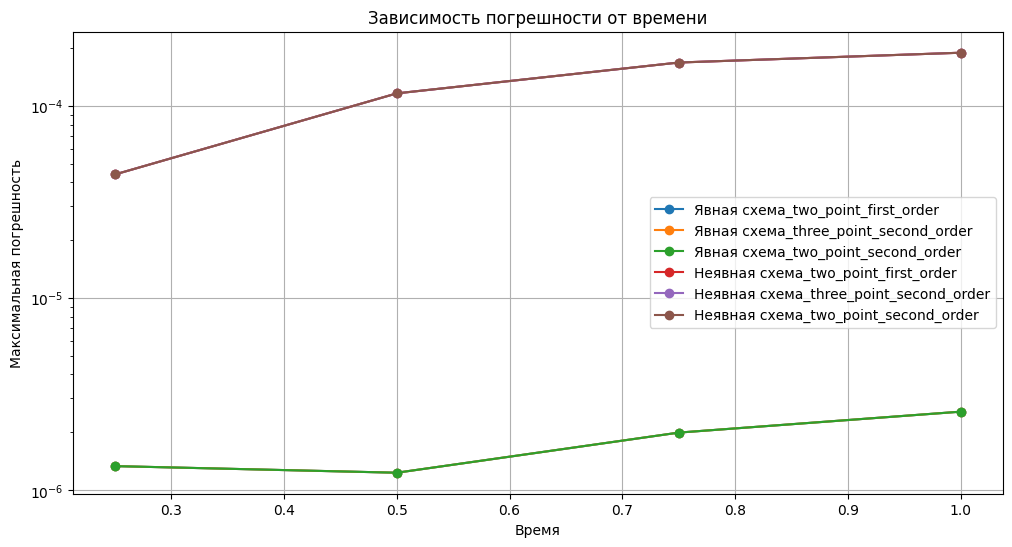


ТАБЛИЦА ПОГРЕШНОСТЕЙ

Явная схема_two_point_first_order:
Время	Погрешность
0.250	1.33e-06
0.500	1.23e-06
0.750	1.99e-06
1.000	2.56e-06

Явная схема_three_point_second_order:
Время	Погрешность
0.250	1.33e-06
0.500	1.23e-06
0.750	1.99e-06
1.000	2.56e-06

Явная схема_two_point_second_order:
Время	Погрешность
0.250	1.33e-06
0.500	1.23e-06
0.750	1.99e-06
1.000	2.56e-06

Неявная схема_two_point_first_order:
Время	Погрешность
0.250	4.40e-05
0.500	1.16e-04
0.750	1.68e-04
1.000	1.89e-04

Неявная схема_three_point_second_order:
Время	Погрешность
0.250	4.40e-05
0.500	1.16e-04
0.750	1.68e-04
1.000	1.89e-04

Неявная схема_two_point_second_order:
Время	Погрешность
0.250	4.40e-05
0.500	1.16e-04
0.750	1.68e-04
1.000	1.89e-04


In [2]:
# Решение неявной схемой
def solve_hyperbolic_implicit(boundary_approx_type="two_point_second_order"):
    u_num = np.zeros((len(T), len(X)))
    u_num[0, :] = psi1(X)
    u_num[1, :] = psi1(X) + psi2(X) * tau + \
         (a_coeff * ddpsi1(X) + b_coeff * dpsi1(X) + c_coeff * psi1(X) + f(X, T[0]) - p_coeff * psi2(X)) * tau**2 / 2
    
    N = len(X) - 1
    
    for n in range(1, len(T) - 1):
        u_prev = u_num[n, :]
        u_prev_prev = u_num[n - 1, :]
        u_next = np.zeros_like(u_prev)

        A = np.zeros(N + 1)
        B = np.zeros(N + 1)
        C = np.zeros(N + 1)
        D = np.zeros(N + 1)

        for i in range(1, N):
            A[i] = -a_coeff / h ** 2 + b_coeff / (2 * h)
            B[i] = q_coeff / tau ** 2 + p_coeff / (2 * tau) + 2 * a_coeff / h ** 2 - c_coeff
            C[i] = -a_coeff / h ** 2 - b_coeff / (2 * h)
            D[i] = f(X[i], T[n + 1]) - u_prev_prev[i] * (q_coeff / tau ** 2 - p_coeff / (2 * tau)) - u_prev[i] * (-2 * q_coeff / tau ** 2)

        t_next = T[n + 1]
        
        if boundary_approx_type == "two_point_first_order":
            A[0] = 0
            B[0] = beta0 - alpha0 / h
            C[0] = alpha0 / h
            D[0] = gamma0(t_next)
            
            A[N] = -alphal / h
            B[N] = alphal / h + betal
            C[N] = 0
            D[N] = gammal(t_next)
 
        elif boundary_approx_type == "three_point_second_order":
            coeff0 = (-alpha0 / 2 / h) / C[1]
            A[0] = 0
            B[0] = (alpha0 * (-3/(2*h)) + beta0) - A[1] * coeff0
            C[0] = (alpha0 * (4/(2*h))) - B[1] * coeff0
            D[0] = gamma0(t_next) - D[1] * coeff0
            
            coeffl = (alphal / 2 / h) / A[N - 1]
            A[N] = -alphal * (4/(2*h)) - B[N - 1] * coeffl
            B[N] = alphal * (3/(2*h)) + betal - C[N - 1] * coeffl
            C[N] = 0
            D[N] = gammal(t_next) - D[N - 1] * coeffl
            
        elif boundary_approx_type == "two_point_second_order":
            A[0] = 0
            B[0] = alpha0 * ((c_coeff * h ** 2 / 2 / a_coeff - 1 - q_coeff * h ** 2 / 2 / a_coeff / tau ** 2 - p_coeff * h ** 2 / 4 / a_coeff / tau) / (h - b_coeff * h ** 2 / 2 / a_coeff)) + beta0
            C[0] = alpha0 * (1 / (h - b_coeff * h ** 2 / 2 / a_coeff))
            D[0] = gamma0(t_next) - alpha0 * (u_prev[0] * (q_coeff * h ** 2 / a_coeff / tau ** 2) + u_prev_prev[0] * (-q_coeff * h ** 2 / 2 / a_coeff / tau ** 2 + p_coeff * h ** 2 / 4 / a_coeff / tau) + f(X[0], t_next) * (h ** 2 / 2 / a_coeff)) / (h - b_coeff * h ** 2 / 2 / a_coeff)
            
            A[N] = alphal * (-1 / (h + b_coeff * h ** 2 / 2 / a_coeff))
            B[N] = alphal * ((1 - c_coeff * h ** 2 / 2 / a_coeff + q_coeff * h ** 2 / 2 / a_coeff / tau ** 2 + p_coeff * h ** 2 / 4 / a_coeff / tau) / (h + b_coeff * h ** 2 / 2 / a_coeff)) + betal
            C[N] = 0
            D[N] = gammal(t_next) - alphal * (u_prev[N] * (-q_coeff * h ** 2 / a_coeff / tau ** 2) + u_prev_prev[N] * (q_coeff * h ** 2 / 2 / a_coeff / tau ** 2 - p_coeff * h ** 2 / 4 / a_coeff / tau) + f(X[N], t_next) * (-1 *h ** 2 / 2 / a_coeff)) / (h + b_coeff * h ** 2 / 2 / a_coeff)
        
        # Метод прогонки
        alpha_prop = np.zeros(N + 1)
        beta_prop = np.zeros(N + 1)

        if abs(B[0]) < 1e-12:
            raise ValueError("Деление на ноль в методе прогонки")
        
        alpha_prop[0] = -C[0] / B[0]
        beta_prop[0] = D[0] / B[0]

        for i in range(1, N + 1):
            denominator = B[i] + A[i] * alpha_prop[i - 1]
            if abs(denominator) < 1e-12:
                raise ValueError("Деление на ноль в методе прогонки")
            if i < N:
                alpha_prop[i] = -C[i] / denominator
            beta_prop[i] = (D[i] - A[i] * beta_prop[i - 1]) / denominator

        u_next[N] = beta_prop[N]

        for i in range(N - 1, -1, -1):
            u_next[i] = alpha_prop[i] * u_next[i + 1] + beta_prop[i]

        u_num[n + 1, :] = u_next

    return u_num


def solve_hyperbolic_explicit(boundary_approx_type="two_point_second_order"):
    sigma = a_coeff * tau ** 2 / h ** 2
    if sigma >= 1.0:
        print(f"ВНИМАНИЕ: Число σ = {sigma:.3f} >= 1.0, схема может быть неустойчива!")

    u_num = np.zeros((len(T), len(X)))
    u_num[0, :] = psi1(X)
    u_num[1, :] = psi1(X) + psi2(X) * tau + \
         (a_coeff * ddpsi1(X) + b_coeff * dpsi1(X) + c_coeff * psi1(X) + f(X, T[0]) - p_coeff * psi2(X)) * tau**2 / 2
    
    N = len(X) - 1
    
    for n in range(1, len(T) - 1):
        u_prev = u_num[n, :]
        u_prev_prev = u_num[n - 1, :]
        u_next = np.zeros_like(u_prev)
        
        for i in range(1, N):
            u_next[i] = (u_prev_prev[i] * (p_coeff / 2 / tau - q_coeff / tau ** 2) + \
                         u_prev[i - 1] * (a_coeff / h ** 2 - b_coeff / 2 / h) + \
                         u_prev[i] * (2 * q_coeff / tau ** 2 - 2 * a_coeff / h ** 2 + c_coeff) + \
                         u_prev[i + 1] * (a_coeff / h ** 2 + b_coeff / 2 / h) + \
                         f(X[i], T[n])) / (q_coeff / tau ** 2 + p_coeff / 2 / tau)
        
        t_next = T[n + 1]
        
        if approx_type == "two_point_first_order":
            u_next[0] = (gamma0(t_next) - (alpha0 / h) * u_next[1]) / (beta0 - (alpha0 / h))
            u_next[N] = (gammal(t_next) + (alphal / h) * u_next[N - 1]) / (betal + (alphal / h))
            
        elif approx_type == "three_point_second_order":
            u_next[0] = (gamma0(t_next) - u_next[1] * (4 * alpha0 / 2 / h) + u_next[2] * (alpha0 / 2 / h )) / \
                        ((-3 * alpha0 / 2 / h) + beta0)
            u_next[N] = (gammal(t_next) - u_next[N - 2] * (alphal / 2 / h) - u_next[N - 1] * (-4 * alphal / 2 / h)) / \
                        ((3 * alphal / 2 / h) + betal)

        elif approx_type == "two_point_second_order":
            b0 = alpha0 * ((c_coeff * h ** 2 / 2 / a_coeff - 1 - q_coeff * h ** 2 / 2 / a_coeff / tau ** 2 - p_coeff * h ** 2 / 4 / a_coeff / tau) / (h - b_coeff * h ** 2 / 2 / a_coeff)) + beta0
            c0 = alpha0 * (1 / (h - b_coeff * h ** 2 / 2 / a_coeff))
            d0 = gamma0(t_next) - alpha0 * (u_prev[0] * (q_coeff * h ** 2 / a_coeff / tau ** 2) + u_prev_prev[0] * (-q_coeff * h ** 2 / 2 / a_coeff / tau ** 2 + p_coeff * h ** 2 / 4 / a_coeff / tau) + f(X[0], t_next) * (h ** 2 / 2 / a_coeff)) / (h - b_coeff * h ** 2 / 2 / a_coeff)
            
            al = alphal * (-1 / (h + b_coeff * h ** 2 / 2 / a_coeff))
            bl = alphal * ((1 - c_coeff * h ** 2 / 2 / a_coeff + q_coeff * h ** 2 / 2 / a_coeff / tau ** 2 + p_coeff * h ** 2 / 4 / a_coeff / tau) / (h + b_coeff * h ** 2 / 2 / a_coeff)) + betal
            dl = gammal(t_next) - alphal * (u_prev[N] * (-q_coeff * h ** 2 / a_coeff / tau ** 2) + u_prev_prev[N] * (q_coeff * h ** 2 / 2 / a_coeff / tau ** 2 - p_coeff * h ** 2 / 4 / a_coeff / tau) + f(X[N], t_next) * (-1 *h ** 2 / 2 / a_coeff)) / (h + b_coeff * h ** 2 / 2 / a_coeff)

            u_next[0] = (d0 - c0 * u_next[1]) / b0
            u_next[N] = (dl - al * u_next[N - 1]) / bl 

        u_num[n + 1, :] = u_next

    return u_num




schemes = [
    'Явная схема',
    'Неявная схема',
]

boundary_approximations = [
    'two_point_first_order',
    'three_point_second_order',
    'two_point_second_order', 
]

results = {}

for scheme_name in schemes:
    for approx_type in boundary_approximations:
        key = f"{scheme_name}_{approx_type}"
        print(f"Вычисление: {key}")
        try:
            if scheme_name == 'Неявная схема':
                u_num = solve_hyperbolic_implicit(approx_type)
            elif scheme_name == 'Явная схема':
                u_num = solve_hyperbolic_explicit(approx_type)
            else:
                raise ValueError(f"Неизвестная схема: {scheme_name}")
            errors = {}
            time_indices = [len(T) // 4, len(T) // 2, 3 * len(T) // 4, len(T) - 1]
            for idx in time_indices:
                if idx < len(u_num):
                    u_analytical = analytical_solution(X, T[idx])
                    error = np.abs(u_num[idx, :] - u_analytical)
                    errors[T[idx]] = np.max(error)
            results[key] = {
                'solution': u_num,
                'errors': errors
            }
        except Exception as e:
            print(f"Ошибка при вычислении {key}: {e}")

def plot_results(results, X, T):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    time_indices = [len(T) // 4, len(T) // 2, 3 * len(T) // 4, len(T) - 1]

    for idx, time_idx in enumerate(time_indices[:4]):
        ax = axes[idx // 2, idx % 2]
        t_val = T[time_idx]

        for scheme_name in ['Явная схема_two_point_first_order',
                          'Явная схема_three_point_second_order',
                          'Явная схема_two_point_second_order',
                          'Неявная схема_two_point_first_order',
                          'Неявная схема_three_point_second_order',
                          'Неявная схема_two_point_second_order']:
            if scheme_name in results:
                u_num = results[scheme_name]['solution']
                ax.plot(X, u_num[time_idx, :], label=scheme_name.split('_')[0])

        u_analytical = analytical_solution(X, t_val)
        ax.plot(X, u_analytical, 'k--', linewidth=2, label='Аналитическое')
        ax.set_title(f'Время t = {t_val:.2f}')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    for key, result in results.items():
        times = list(result['errors'].keys())
        errors = list(result['errors'].values())
        plt.semilogy(times, errors, 'o-', label=key)

    plt.xlabel('Время')
    plt.ylabel('Максимальная погрешность')
    plt.title('Зависимость погрешности от времени')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    plot_results(results, X, T)

    print("\n" + "=" * 60)
    print("ТАБЛИЦА ПОГРЕШНОСТЕЙ")
    print("=" * 60)

    for scheme_name in results.keys():
        print(f"\n{scheme_name}:")
        print("Время\tПогрешность")
        for time, error in results[scheme_name]['errors'].items():
            print(f"{time:.3f}\t{error:.2e}")